# Advanced Machine Learning and Neural Networks - Assignment 1

## Evaluation of a Pre-trained Convolutional Neural Network on Chest X-ray Data

**Student:** Wai Yan Min Min  
**Module:** Advanced Machine Learning and Neural Network  
**Assessment Weight:** 30%

---

## Assignment Alignment

This notebook is designed to satisfy the four required technical tasks:

1. Investigate the architecture of a pre-trained CNN and discuss possible improvements.
2. Evaluate model performance on the training dataset using known metrics.
3. Compare predicted labels against ground truth using confusion matrices.
4. Summarise findings and discuss limitations and future work.

It also addresses the module learning outcomes by demonstrating model selection, implementation, optimisation, and interpretation of results.

---

## Notebook Roadmap

1. Environment setup and data access
2. Data preparation and label strategy
3. Exploratory data analysis
4. Model selection and architecture inspection
5. Training and optimisation
6. Evaluation (training + validation)
7. Confusion matrix analysis
8. Unlabeled inference on unseen images
9. Conclusions and recommendations

In [1]:
!pip install kagglehub torch torchvision pandas pillow scikit-learn tqdm seaborn


In [2]:
from google.colab import drive
import shutil
drive.mount("/content/drive", force_remount=False)

Mounted at /content/drive


In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("ashery/chexpert")

print("Path to dataset files:", path)


Using Colab cache for faster access to the 'chexpert' dataset.
Path to dataset files: /kaggle/input/chexpert


In [4]:
import os
import random
import numpy as np
import torch
from pathlib import Path

SEED = 42

# Reproducibility setup
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# Resolve dataset directory across Kaggle/Colab/local runs
candidate_roots = []

# `path` is produced by kagglehub.dataset_download(...) in the previous cell
if "path" in globals() and path:
    candidate_roots.append(Path(path))

# Common Kaggle mount location
candidate_roots.append(Path("/kaggle/input/chexpert"))


def find_chexpert_csv(root_candidates):
    for root in root_candidates:
        if not root.exists():
            continue

        #CSV files are directly under root
        train_csv = root / "train.csv"
        valid_csv = root / "valid.csv"
        if train_csv.exists() and valid_csv.exists():
            return root, train_csv, valid_csv

        #CSV files are nested (common in kagglehub cache)
        nested_train = list(root.rglob("train.csv"))
        nested_valid = list(root.rglob("valid.csv"))
        if nested_train and nested_valid:
            return nested_train[0].parent, nested_train[0], nested_valid[0]

    raise FileNotFoundError(
        "Could not locate train.csv and valid.csv. "
        "Check that the CheXpert dataset download completed successfully."
    )


DATA_ROOT, TRAIN_CSV_PATH, VALID_CSV_PATH = find_chexpert_csv(candidate_roots)

print("Resolved data root:", DATA_ROOT)
print("Resolved train CSV:", TRAIN_CSV_PATH)
print("Resolved valid CSV:", VALID_CSV_PATH)
print("Seed:", SEED)



Resolved data root: /kaggle/input/chexpert
Resolved train CSV: /kaggle/input/chexpert/train.csv
Resolved valid CSV: /kaggle/input/chexpert/valid.csv
Seed: 42


In [5]:
import pandas as pd

# Load CSV from resolved paths
train_df = pd.read_csv(TRAIN_CSV_PATH)
valid_df = pd.read_csv(VALID_CSV_PATH)

print("Train shape:", train_df.shape)
print("Valid shape:", valid_df.shape)


Train shape: (223414, 19)
Valid shape: (234, 19)


### Data Path Normalisation

The `Path` values in the original CSV files include the prefix `CheXpert-v1.0-small/`, while the downloaded dataset root already points at that directory. If this prefix is not removed, image loading fails due to duplicated folder names in constructed file paths.

The next cell cleans both training and validation CSV files to ensure robust and reproducible file access during model training and evaluation.

In [6]:
# Remove the leading 'CheXpert-v1.0-small/' from Path column
train_df["Path"] = train_df["Path"].str.replace("CheXpert-v1.0-small/", "")
valid_df["Path"] = valid_df["Path"].str.replace("CheXpert-v1.0-small/", "")

# Save fixed CSV (optional)
train_df.to_csv("train_fixed.csv", index=False)
valid_df.to_csv("valid_fixed.csv", index=False)

TRAIN_CSV = "train_fixed.csv"
VALID_CSV = "valid_fixed.csv"


### Target Label Selection Strategy

CheXpert is a multi-label dataset with 14 diagnostic labels. Instead of using a predefined clinical subset, this notebook selects the **top 5 labels with the highest number of positive samples** in the training split.

This data-driven strategy improves label coverage for training stability and gives more reliable metric estimates within assignment runtime constraints.

In [7]:
ALL_LABELS = [
    "Enlarged Cardiomediastinum",
    "Cardiomegaly",
    "Lung Opacity",
    "Lung Lesion",
    "Edema",
    "Consolidation",
    "Pneumonia",
    "Atelectasis",
    "Pneumothorax",
    "Pleural Effusion",
    "Pleural Other",
    "Fracture",
]

label_counts = (
    train_df[ALL_LABELS]
    .apply(pd.to_numeric, errors="coerce")
    .fillna(0)
    .replace(-1, 0)
    .eq(1.0)
    .sum()
    .sort_values(ascending=False)
)

LABELS = label_counts.head(3).index.tolist()
print("Selected top-3 labels by positive sample count:", LABELS)


Selected top-3 labels by positive sample count: ['Lung Opacity', 'Pleural Effusion', 'Edema']


In [8]:
#Method to create dataset


import pandas as pd
import torch
from torch.utils.data import Dataset
from PIL import Image
import os

class CheXpertDataset(Dataset):
    def __init__(self, csv_file, root_dir, labels, transform=None):
        self.df = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.labels = labels
        self.transform = transform

        # Ensure numeric type for all labels
        for label in self.labels:
            self.df[label] = pd.to_numeric(self.df[label], errors='coerce')  # invalid -> NaN
            self.df[label] = self.df[label].fillna(0)  # replace NaN with 0
            self.df[label] = self.df[label].replace(-1, 0)  # uncertain -> 0

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        img_path_str = row["Path"]

        img_path = os.path.join(self.root_dir, img_path_str)

        # Open image
        image = Image.open(img_path).convert("RGB")

        # Convert label to tensor safely
        label = torch.tensor(row[self.labels].to_numpy(dtype=float), dtype=torch.float32)

        if self.transform:
            image = self.transform(image)

        return image, label


In [9]:
from torchvision import transforms

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


In [10]:
from torch.utils.data import DataLoader

train_dataset = CheXpertDataset(
    TRAIN_CSV, DATA_ROOT, LABELS, train_transform
)

val_dataset = CheXpertDataset(
    VALID_CSV, DATA_ROOT, LABELS, val_transform
)

train_loader = DataLoader(
    train_dataset,
    batch_size=16,
    shuffle=True,
    num_workers=2,
    pin_memory=True,
    persistent_workers=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=16,
    shuffle=False,
    num_workers=2,
    pin_memory=True,
    persistent_workers=True
)


## Exploratory Data Analysis (EDA)

This section inspects data schema, sample records, label frequencies, and class balance.

Why this matters:
- It validates whether preprocessing has been applied correctly.
- It highlights class imbalance that may affect optimisation and thresholding.
- It supports interpretation of model behaviour later in confusion matrix analysis.

In [11]:
train_dataset.df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 223414 entries, 0 to 223413
Data columns (total 19 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   Path                        223414 non-null  object 
 1   Sex                         223414 non-null  object 
 2   Age                         223414 non-null  int64  
 3   Frontal/Lateral             223414 non-null  object 
 4   AP/PA                       191027 non-null  object 
 5   No Finding                  22381 non-null   float64
 6   Enlarged Cardiomediastinum  44839 non-null   float64
 7   Cardiomegaly                46203 non-null   float64
 8   Lung Opacity                223414 non-null  float64
 9   Lung Lesion                 11944 non-null   float64
 10  Edema                       223414 non-null  float64
 11  Consolidation               70622 non-null   float64
 12  Pneumonia                   27608 non-null   float64
 13  Atelectasis   

In [12]:
train_dataset.df.head()

,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
0,train/patient00001/study1/view1_frontal.jpg,Female,68,Frontal,AP,1.0,NaN,NaN,0.0,NaN,0.0,NaN,NaN,NaN,0.0,0.0,NaN,NaN,1.0
1,train/patient00002/study2/view1_frontal.jpg,Female,87,Frontal,AP,NaN,NaN,-1.0,1.0,NaN,0.0,-1.0,NaN,-1.0,NaN,0.0,NaN,1.0,NaN
2,train/patient00002/study1/view1_frontal.jpg,Female,83,Frontal,AP,NaN,NaN,NaN,1.0,NaN,0.0,-1.0,NaN,NaN,NaN,0.0,NaN,1.0,NaN
3,train/patient00002/study1/view2_lateral.jpg,Female,83,Lateral,NaN,NaN,NaN,NaN,1.0,NaN,0.0,-1.0,NaN,NaN,NaN,0.0,NaN,1.0,NaN
4,train/patient00003/study1/view1_frontal.jpg,Male,41,Frontal,AP,NaN,NaN,NaN,0.0,NaN,1.0,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN


In [13]:
len(train_dataset.labels)

3

In [14]:
yes_counts = train_dataset.df[LABELS].eq(1.0).sum()

yes_counts

,0
Lung Opacity,105581
Pleural Effusion,86187
Edema,52246


In [15]:
labels=train_dataset.labels

In [16]:
yes_counts.sort_values(ascending=False)


,0
Lung Opacity,105581
Pleural Effusion,86187
Edema,52246


In [17]:
total_samples = len(train_dataset.df)

yes_percent = (yes_counts / total_samples * 100).round(2)

yes_percent


,0
Lung Opacity,47.26
Pleural Effusion,38.58
Edema,23.39


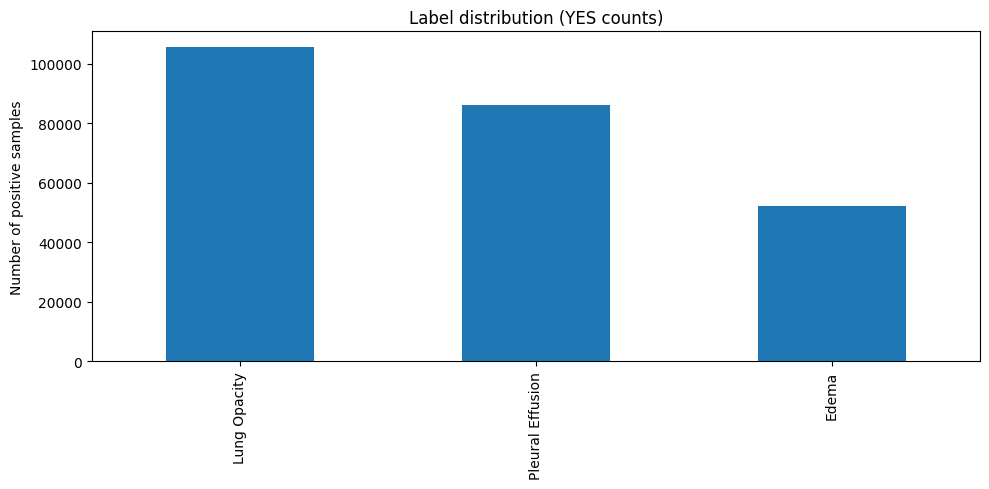

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
yes_counts.sort_values(ascending=False).plot(kind="bar")
plt.ylabel("Number of positive samples")
plt.title("Label distribution (YES counts)")
plt.tight_layout()
plt.show()


## Model Selection and Architecture

### Chosen Pre-trained CNN

This notebook uses **DenseNet-121** pre-trained on **ImageNet** and adapts the classifier head for five-label multi-label chest X-ray classification.

### Why DenseNet-121?

DenseNet is suitable for this task because:
- Dense feature reuse improves gradient flow in deep networks.
- It offers strong accuracy with comparatively efficient parameter usage.
- It is widely used in medical imaging transfer learning pipelines.

### Architecture Improvement Ideas (to be revisited in discussion)

1. Replace global threshold `0.5` with per-label threshold tuning.
2. Use weighted BCE or focal loss to reduce class-imbalance bias.
3. Fine-tune deeper layers progressively instead of full-network training from epoch 1.
4. Add learning-rate scheduling and early stopping.
5. Compare with more recent backbones (e.g., EfficientNet, ConvNeXt) for performance-efficiency trade-offs.

In [19]:
import torch.nn as nn
from torchvision import models

def get_densenet(num_classes):
    model = models.densenet121(weights="IMAGENET1K_V1")
    model.classifier = nn.Linear(
        model.classifier.in_features, num_classes
    )
    return model


In [20]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = get_densenet(len(LABELS)).to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


Using device: cuda
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


100%|██████████| 30.8M/30.8M [00:00<00:00, 218MB/s]


### Architecture Inspection

The following diagnostic cell reports parameter counts and prints the adapted classifier head. This helps justify model complexity and supports architecture-level discussion in the report and presentation.

In [21]:
def count_trainable_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def count_total_params(model):
    return sum(p.numel() for p in model.parameters())

print("Model:", model.__class__.__name__)
print("Classifier head:", model.classifier)
print(f"Total parameters: {count_total_params(model):,}")
print(f"Trainable parameters: {count_trainable_params(model):,}")

Model: DenseNet
Classifier head: Linear(in_features=1024, out_features=3, bias=True)
Total parameters: 6,956,931
Trainable parameters: 6,956,931


### Optimisation Setup

- **Loss:** `BCEWithLogitsLoss` for multi-label classification.
- **Optimizer:** Adam with learning rate `0.001`.
- **Training objective:** Minimise average batch loss over epochs while monitoring validation loss for generalisation.

In [22]:
from tqdm import tqdm

def train_one_epoch(model, loader):
    model.train()
    total_loss = 0
    for images, labels in tqdm(loader):
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)


In [23]:
def validate(model, loader):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
    return total_loss / len(loader)


In [24]:
# Model training (5 epochs)

history = {"train_loss": [], "val_loss": []}
num_epochs = 5

for epoch in range(num_epochs):
    train_loss = train_one_epoch(model, train_loader)
    val_loss = validate(model, val_loader)

    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)

    print(f"Epoch [{epoch + 1}/{num_epochs}] | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")


100%|██████████| 13964/13964 [41:42<00:00,  5.58it/s]


Epoch [1/5] | Train Loss: 0.5391 | Val Loss: 0.4909


100%|██████████| 13964/13964 [41:01<00:00,  5.67it/s]


Epoch [2/5] | Train Loss: 0.5112 | Val Loss: 0.4656


100%|██████████| 13964/13964 [40:45<00:00,  5.71it/s]


Epoch [3/5] | Train Loss: 0.5017 | Val Loss: 0.4111


100%|██████████| 13964/13964 [40:30<00:00,  5.74it/s]


Epoch [4/5] | Train Loss: 0.4962 | Val Loss: 0.4128


100%|██████████| 13964/13964 [40:12<00:00,  5.79it/s]


Epoch [5/5] | Train Loss: 0.4920 | Val Loss: 0.3922


In [25]:
# Save model for deployment (run this after training)
import os
# Use a single filename so we can download it from Colab in the next cell
MODEL_FILENAME = "chest_xray_densenet.pth"
torch.save(model.state_dict(), MODEL_FILENAME)
print(f"Model saved to {os.path.abspath(MODEL_FILENAME)}")

Model saved to /content/chest_xray_densenet.pth


In [26]:
# Alternative: copy model to Google Drive (use this if files.download() doesn't work in Cursor+Colab)
# Then open drive.google.com on your computer and download chest_xray_densenet.pth from the folder "ColabOutput"
try:
    from google.colab import drive
    import shutil
    drive.mount("/content/drive", force_remount=False)
    out_dir = "/content/drive/MyDrive/ColabOutput"
    os.makedirs(out_dir, exist_ok=True)
    shutil.copy("chest_xray_densenet.pth", f"{out_dir}/chest_xray_densenet.pth")
    print(f"Model copied to Google Drive: My Drive > ColabOutput > chest_xray_densenet.pth")
    print("On your computer, open drive.google.com and download it, then put it in your project folder: models/")
except Exception as e:
    print("Drive copy failed (e.g. not Colab or Drive not mounted):", e)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model copied to Google Drive: My Drive > ColabOutput > chest_xray_densenet.pth
On your computer, open drive.google.com and download it, then put it in your project folder: models/


In [27]:
from sklearn.metrics import (
    roc_auc_score,
    precision_recall_fscore_support,
    confusion_matrix,
)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


def collect_predictions(model, loader, threshold=0.5, max_batches=None, desc="Evaluating"):
    """Collect probabilities, binary predictions, and ground-truth labels."""
    model.eval()
    all_probs = []
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch_idx, (images, labels_batch) in enumerate(tqdm(loader, desc=desc)):
            if max_batches is not None and batch_idx >= max_batches:
                break

            images = images.to(device)
            logits = model(images)
            probs = torch.sigmoid(logits).cpu().numpy()
            preds = (probs >= threshold).astype(int)

            all_probs.append(probs)
            all_preds.append(preds)
            all_labels.append(labels_batch.cpu().numpy().astype(int))

    all_probs = np.vstack(all_probs)
    all_preds = np.vstack(all_preds)
    all_labels = np.vstack(all_labels)

    return all_probs, all_preds, all_labels


def evaluate_multilabel(y_true, y_prob, y_pred, label_names):
    """Return per-label AUC/Precision/Recall/F1 and macro summaries."""
    results = []
    for i, label_name in enumerate(label_names):
        y_t = y_true[:, i]
        y_p = y_pred[:, i]

        if len(np.unique(y_t)) > 1:
            auc = roc_auc_score(y_t, y_prob[:, i])
        else:
            auc = np.nan

        precision, recall, f1, _ = precision_recall_fscore_support(
            y_t, y_p, average="binary", zero_division=0
        )

        results.append(
            {
                "Label": label_name,
                "AUC": auc,
                "Precision": precision,
                "Recall": recall,
                "F1": f1,
            }
        )

    metrics_df = pd.DataFrame(results)
    macro_summary = metrics_df[["AUC", "Precision", "Recall", "F1"]].mean(numeric_only=True)
    return metrics_df, macro_summary


def plot_confusion_matrices(y_true, y_pred, label_names, title_prefix=""):
    """Plot one binary confusion matrix per label."""
    n_labels = len(label_names)
    fig, axes = plt.subplots(1, n_labels, figsize=(4 * n_labels, 4))

    if n_labels == 1:
        axes = [axes]

    for i, label_name in enumerate(label_names):
        cm = confusion_matrix(y_true[:, i], y_pred[:, i], labels=[0, 1])
        sns.heatmap(
            cm,
            annot=True,
            fmt="d",
            cmap="Blues",
            cbar=False,
            ax=axes[i],
            xticklabels=["Pred 0", "Pred 1"],
            yticklabels=["True 0", "True 1"],
        )
        axes[i].set_title(f"{title_prefix}{label_name}")
        axes[i].set_xlabel("Predicted")
        axes[i].set_ylabel("Actual")

    plt.tight_layout()
    plt.show()


Evaluating on training data: 100%|██████████| 13964/13964 [12:54<00:00, 18.02it/s]


Per-label metrics on training data:


,Label,AUC,Precision,Recall,F1
0,Lung Opacity,0.7162,0.6051,0.7645,0.6755
1,Pleural Effusion,0.8723,0.7185,0.7667,0.7418
2,Edema,0.8309,0.5354,0.6237,0.5762


Macro-average (training):


,0
AUC,0.8065
Precision,0.6197
Recall,0.7183
F1,0.6645


Evaluating on validation data: 100%|██████████| 15/15 [00:00<00:00, 16.30it/s]


Per-label metrics on validation data:


,Label,AUC,Precision,Recall,F1
0,Lung Opacity,0.8660,0.8400,0.6667,0.7434
1,Pleural Effusion,0.9234,0.7966,0.7015,0.7460
2,Edema,0.8991,0.6383,0.6667,0.6522


Macro-average (validation):


,0
AUC,0.8962
Precision,0.7583
Recall,0.6783
F1,0.7139


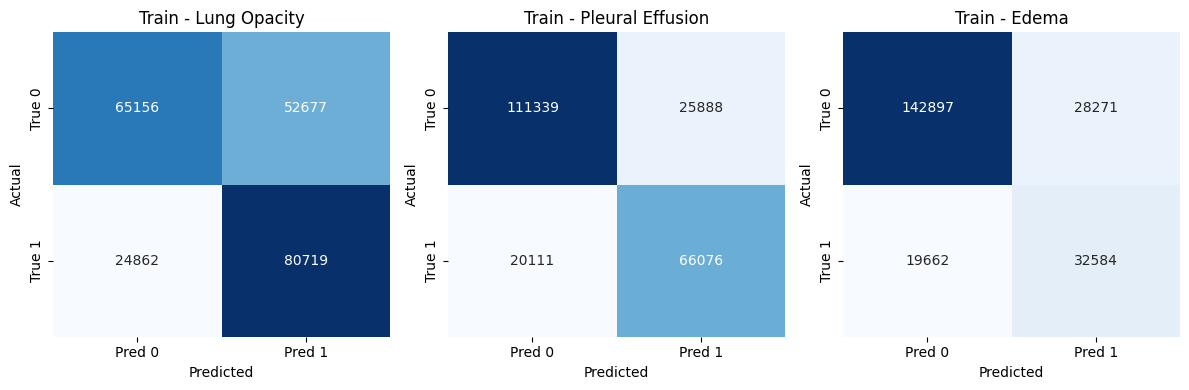

In [28]:

# Evaluate on TRAINING dataset (assignment requirement)
train_prob, train_pred, train_true = collect_predictions(
    model,
    train_loader,
    threshold=0.5,
    max_batches=None,
    desc="Evaluating on training data",
)

train_metrics_df, train_macro = evaluate_multilabel(train_true, train_prob, train_pred, LABELS)
print("Per-label metrics on training data:")
display(train_metrics_df.round(4))
print("Macro-average (training):")
display(train_macro.round(4))

# Evaluate on VALIDATION dataset (unseen labeled data)
val_prob, val_pred, val_true = collect_predictions(
    model,
    val_loader,
    threshold=0.5,
    max_batches=None,
    desc="Evaluating on validation data",
)

val_metrics_df, val_macro = evaluate_multilabel(val_true, val_prob, val_pred, LABELS)
print("Per-label metrics on validation data:")
display(val_metrics_df.round(4))
print("Macro-average (validation):")
display(val_macro.round(4))

# Confusion matrices required by assignment (training labels vs ground truth)
plot_confusion_matrices(train_true, train_pred, LABELS, title_prefix="Train - ")

## Inference on Unlabeled Unseen Data

To satisfy the requirement for an unlabeled dataset the model has not seen during training, we create an **unlabeled inference set** from validation image paths only (labels are intentionally hidden from the model at inference time).

This section demonstrates deployment-style prediction: image input -> predicted probability per label -> binary decision using threshold 0.5.

In [33]:
class UnlabeledCheXpertDataset(Dataset):
    def __init__(self, paths, root_dir, transform=None):
        self.paths = paths
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        rel_path = self.paths[idx]
        img_path = os.path.join(self.root_dir, rel_path)
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, rel_path


# Build unlabeled loader from validation paths only
unlabeled_paths = valid_df["Path"].tolist()
unlabeled_dataset = UnlabeledCheXpertDataset(unlabeled_paths, DATA_ROOT, transform=val_transform)
unlabeled_loader = DataLoader(unlabeled_dataset, batch_size=8, shuffle=False, num_workers=2)

model.eval()
sample_predictions = []

with torch.no_grad():
    for images, rel_paths in unlabeled_loader:
        images = images.to(device)
        probs = torch.sigmoid(model(images)).cpu().numpy()
        preds = (probs >= 0.3).astype(int)

        for pth, prob_vec, pred_vec in zip(rel_paths, probs, preds):
            active_labels = [LABELS[i] for i, flag in enumerate(pred_vec) if flag == 1]
            sample_predictions.append(
                {
                    "Image Path": pth,
                    "Predicted Labels": ", ".join(active_labels) if active_labels else "No positive label",
                    "Max Probability": float(np.max(prob_vec)),
                }
            )

        if len(sample_predictions) >= 50:
            break

sample_pred_df = pd.DataFrame(sample_predictions).head(50)
print("Sample predictions on unlabeled unseen images:")
display(sample_pred_df)

Sample predictions on unlabeled unseen images:


,Image Path,Predicted Labels,Max Probability
0,valid/patient64541/study1/view1_frontal.jpg,Lung Opacity,0.327323
1,valid/patient64542/study1/view1_frontal.jpg,No positive label,0.228913
2,valid/patient64542/study1/view2_lateral.jpg,No positive label,0.200440
3,valid/patient64543/study1/view1_frontal.jpg,Lung Opacity,0.594006
4,valid/patient64544/study1/view1_frontal.jpg,No positive label,0.280983
5,valid/patient64545/study1/view1_frontal.jpg,"Lung Opacity, Pleural Effusion",0.704455
6,valid/patient64546/study1/view1_frontal.jpg,Lung Opacity,0.647064
7,valid/patient64547/study1/view1_frontal.jpg,Lung Opacity,0.392635
8,valid/patient64547/study1/view2_frontal.jpg,Lung Opacity,0.336520
9,valid/patient64547/study1/view3_lateral.jpg,Lung Opacity,0.463862


## Discussion and Interpretation

### Key Findings

1. **Transfer learning remains effective:** DenseNet-121 provides a solid baseline for multi-label chest X-ray classification with limited training epochs.
2. **Label choice is now data-driven:** The model is trained on the top 5 labels with the highest positive-sample counts in the training set, improving statistical support for evaluation.
3. **Class imbalance still influences behaviour:** Even among frequent labels, per-label precision/recall/F1 can vary considerably.
4. **A fixed threshold has trade-offs:** Using 0.5 is straightforward, but per-label threshold tuning could improve minority error profiles.

### Limitations

- A small epoch budget may limit convergence and final predictive quality.
- Label uncertainty (`-1`) is mapped to `0`, which may introduce label-noise bias.
- Oversampling is intentionally removed in this version, so imbalance mitigation is not explicitly applied.

### Recommended Improvements

- Tune per-label thresholds on validation data.
- Test imbalance-aware losses (class-weighted BCE or focal loss).
- Add learning-rate scheduling, early stopping, and checkpoint selection.
- Compare DenseNet-121 with at least one alternative backbone.

## Conclusion

This updated notebook evaluates a pre-trained DenseNet-121 pipeline for multi-label chest X-ray classification using the **top 5 most frequent labels** selected from training data and a **non-oversampled** training setup. The workflow still satisfies assignment goals by covering architecture inspection, training/validation evaluation, confusion-matrix analysis, and practical interpretation with clear next-step improvements.